In [1]:
pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
  
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt
# Import packages
import os
import pickle

import numpy as np 
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from scipy import stats
import scipy.optimize as optimize 

[*********************100%***********************]  1 of 1 completed


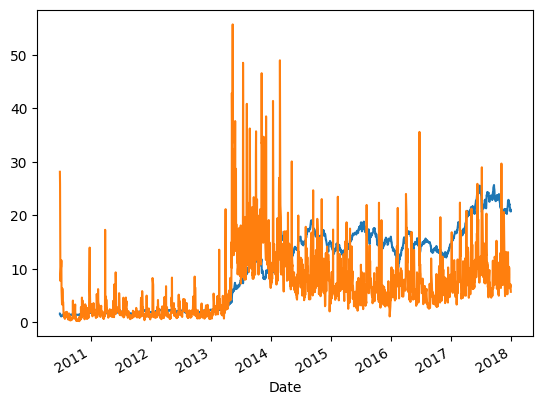

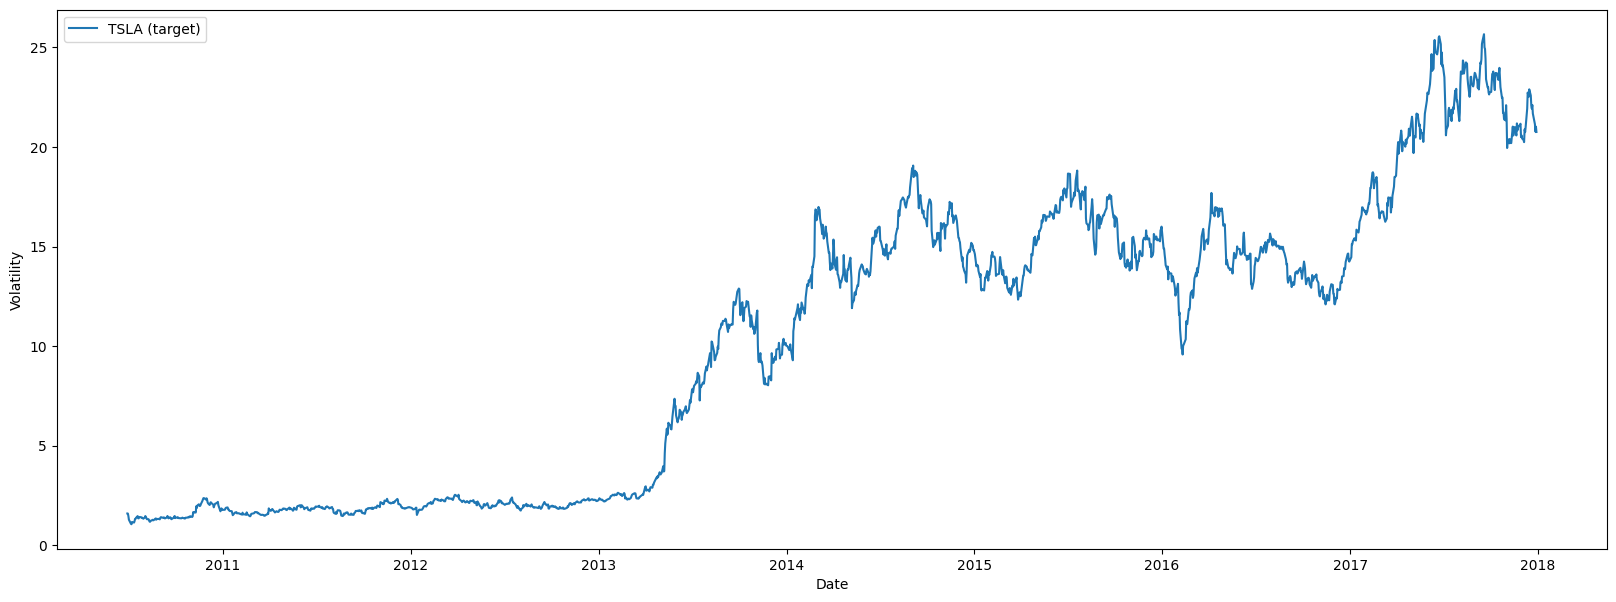

In [3]:

start = "2010-01-01"
end = "2018-01-01"
tesla_train = yf.download('TSLA',start=start, end =end)
tesla_train['Close'].head()
tesla_train['Close'].plot()
(tesla_train['Volume']/10000000).plot()
movAv2 = (tesla_train['Volume']).rolling(window=10).mean()
movAv3 = (tesla_train['Volume']).rolling(window=30).mean()
std =  (tesla_train['Volume']).rolling(window=30).std()
zscore = (movAv2-movAv3)/std
parameter = 0.5
fig, ax = plt.figure(figsize=(20,7)), plt.axes()
sns.lineplot(data=tesla_train,x='Date',y='Close',label='TSLA (target)',ax=ax)
plt.ylabel('Volatility')
plt.show()    




  



[*********************100%***********************]  1 of 1 completed


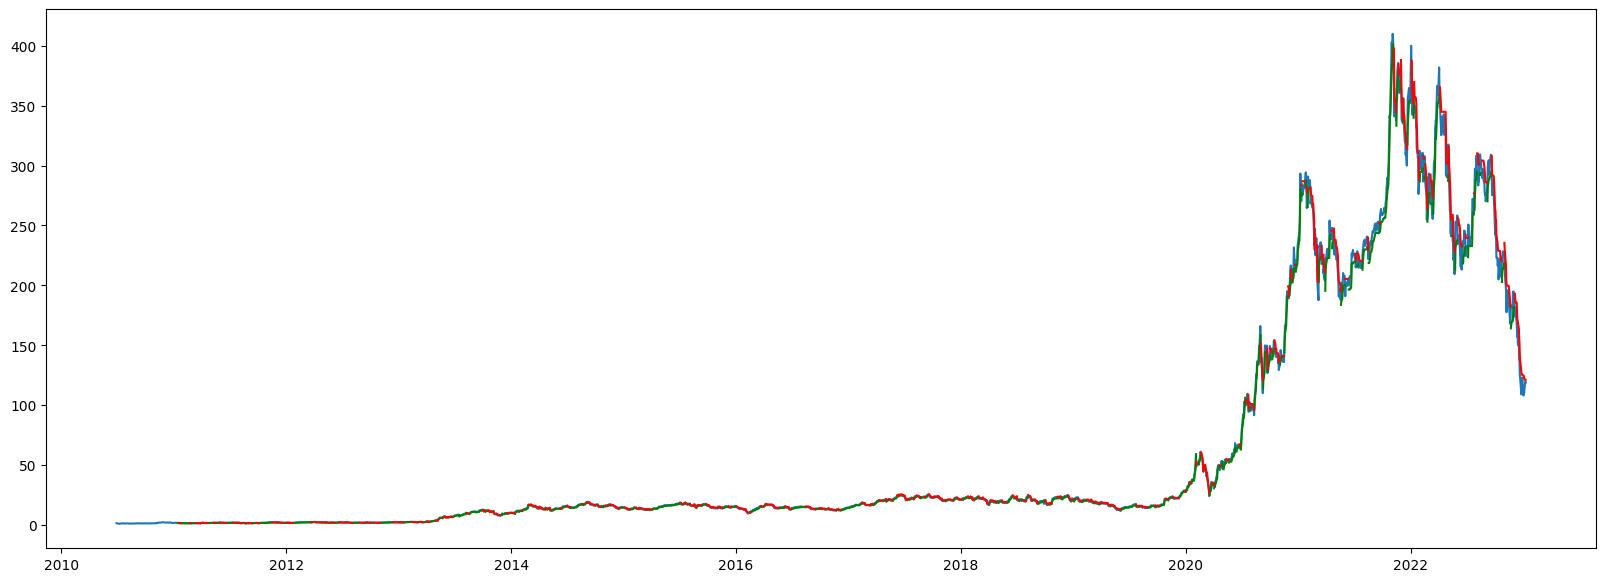

In [17]:
## Describe trend using supertrend indicator

## plot supertrend indicator
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

def calculate_supertrend(df, period, multiplier):
    """
    Calculates the Supertrend indicator for a given DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame containing High, Low, and Close data.
        period (int): Period to use for the exponential moving average of the True Range.
        multiplier (float): Multiplier to use for the calculation of the bands.

    Returns:
        pandas.DataFrame: DataFrame containing the Supertrend, Final Lowerband, and Final Upperband.
    """

    high_prices = df['High']
    low_prices = df['Low']
    close_prices = df['Close']
    
    price_diffs = [high_prices - low_prices, 
                   high_prices - close_prices.shift(), 
                   close_prices.shift() - low_prices]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    atr = true_range.ewm(alpha=1/period, min_periods=period).mean() 
    hl2 = (high_prices + low_prices) / 2
    final_upper_band = upper_band = hl2 + (multiplier * atr)
    final_lower_band = lower_band = hl2 - (multiplier * atr)
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr_idx, prev_idx = i, i-1
        
        if close_prices[curr_idx] > final_upper_band[prev_idx]:
            supertrend[curr_idx] = True
        elif close_prices[curr_idx] < final_lower_band[prev_idx]:
            supertrend[curr_idx] = False
        else:
            supertrend[curr_idx] = supertrend[prev_idx]
            
            if supertrend[curr_idx] == True and final_lower_band[curr_idx] < final_lower_band[prev_idx]:
                final_lower_band[curr_idx] = final_lower_band[prev_idx]
            if supertrend[curr_idx] == False and final_upper_band[curr_idx] > final_upper_band[prev_idx]:
                final_upper_band[curr_idx] = final_upper_band[prev_idx]

        if supertrend[curr_idx] == True:
            final_upper_band[curr_idx] = np.nan
        else:
            final_lower_band[curr_idx] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lower_band,
        'Final Upperband': final_upper_band
    }, index=df.index)
    
    
period = 140
atr_multiplier = 1.0

symbol = 'TSLA'
df = yf.download(symbol, start=start,end=end)
supertrend = calculate_supertrend(df, period, atr_multiplier)
df = df.join(supertrend)
# visualization
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()


In [18]:
def symbol_superTrend(symbol,start, end,atr_period,atr_multiplier):
  df = yf.download(symbol, start=start,end=end)
  supertrend = calculate_supertrend(df, atr_period, atr_multiplier)
  df = df.join(supertrend)
  return df

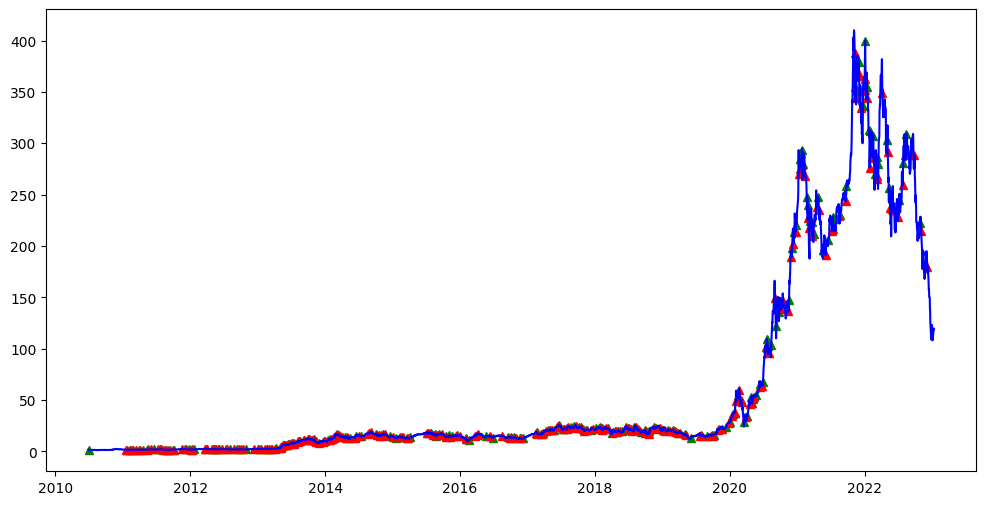

In [19]:


def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend'] ### correct
    close = df['Close']   ## close 
    in_position = False    
    equity = investment   
    commission = 5
    share = 0
    entry = []
    exit = []
    equityCurve = []
    returnCurve = []
    allocationCurve = []
    value = equity
    prev_value = equity
    change = (value - prev_value)
    for i in range(2, len(df)):
        change = (value - prev_value)/prev_value
        allocation = equity*0.5*max(min(1,1+change*1),0)
        prev_value = value
        if not in_position and is_uptrend[i]:
            share = (allocation/ close[i] ) 
            equity -= share * close[i]
            entry.append((df.index[i], close[i]))
            allocationCurve += [(df.index[i], allocation)]
            in_position = True
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((df.index[i], close[i]))
            allocationCurve += [(df.index[i], 0)]
            in_position = False
            share =0
        value = share*close[i]+equity -commission
        equityCurve += [(df.index[i],equity)]
        returnCurve += [(df.index[i], share*close[i]+equity-commission)]
    if in_position:
        equity += share * close[i] - commission
    earning = equity - investment
    roi = round(earning/investment*100,2)
    return entry, exit, equity,equityCurve, returnCurve,allocationCurve

entry, exit, roi,equityCurve,returnCurve,allocationCurve = backtest_supertrend(df, 100000)
closePlot = df['Close'].reset_index()
plt.figure(figsize=(12,6))
plt.plot(*zip(*entry),color='g', linestyle='None', marker='^')
plt.plot(*zip(*exit), color='red',linestyle='None',marker='^')
plt.plot(df['Close'],color='b')
    

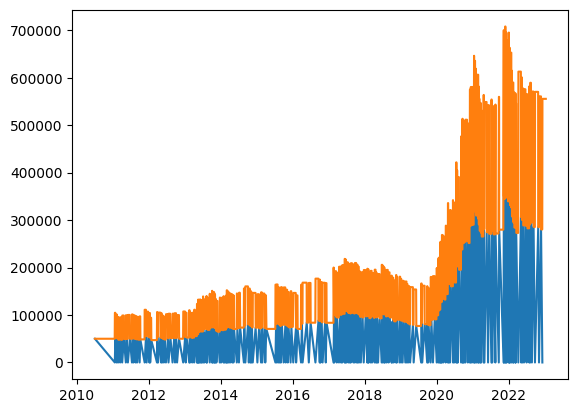

In [20]:
plt.plot(*zip(*allocationCurve))
plt.plot(*zip(*equityCurve))

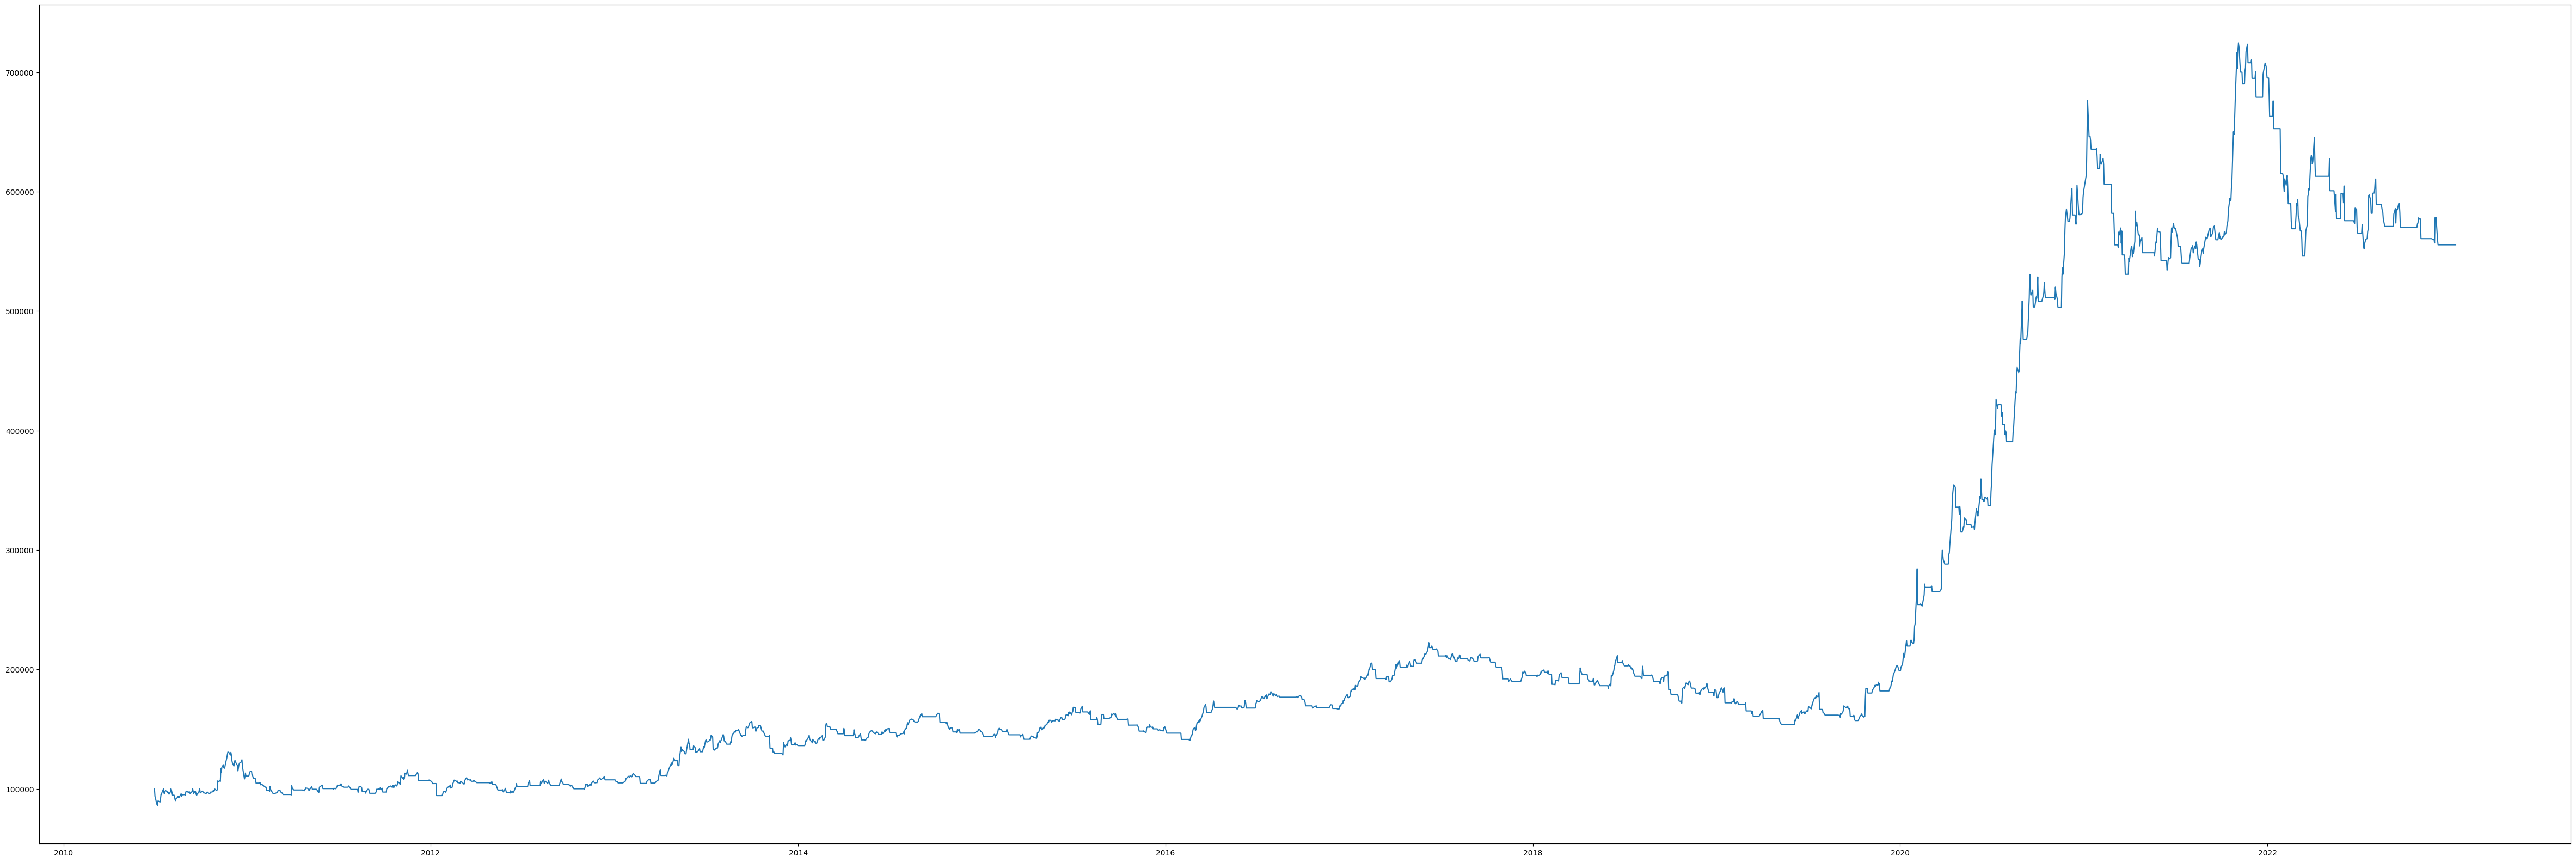

In [21]:
plt.figure(figsize=(60,20))
plt.plot(*zip(*returnCurve))

[*********************100%***********************]  1 of 1 completed
TSLA  return: 5583223.95618517
[*********************100%***********************]  1 of 1 completed
AAPL  return: 5356347.719637084
[*********************100%***********************]  1 of 1 completed
MSFT  return: 591248.7073969706
[*********************100%***********************]  1 of 1 completed
META  return: 1020683.8254680824
[*********************100%***********************]  1 of 1 completed
AMZN  return: 1722407.3422036404


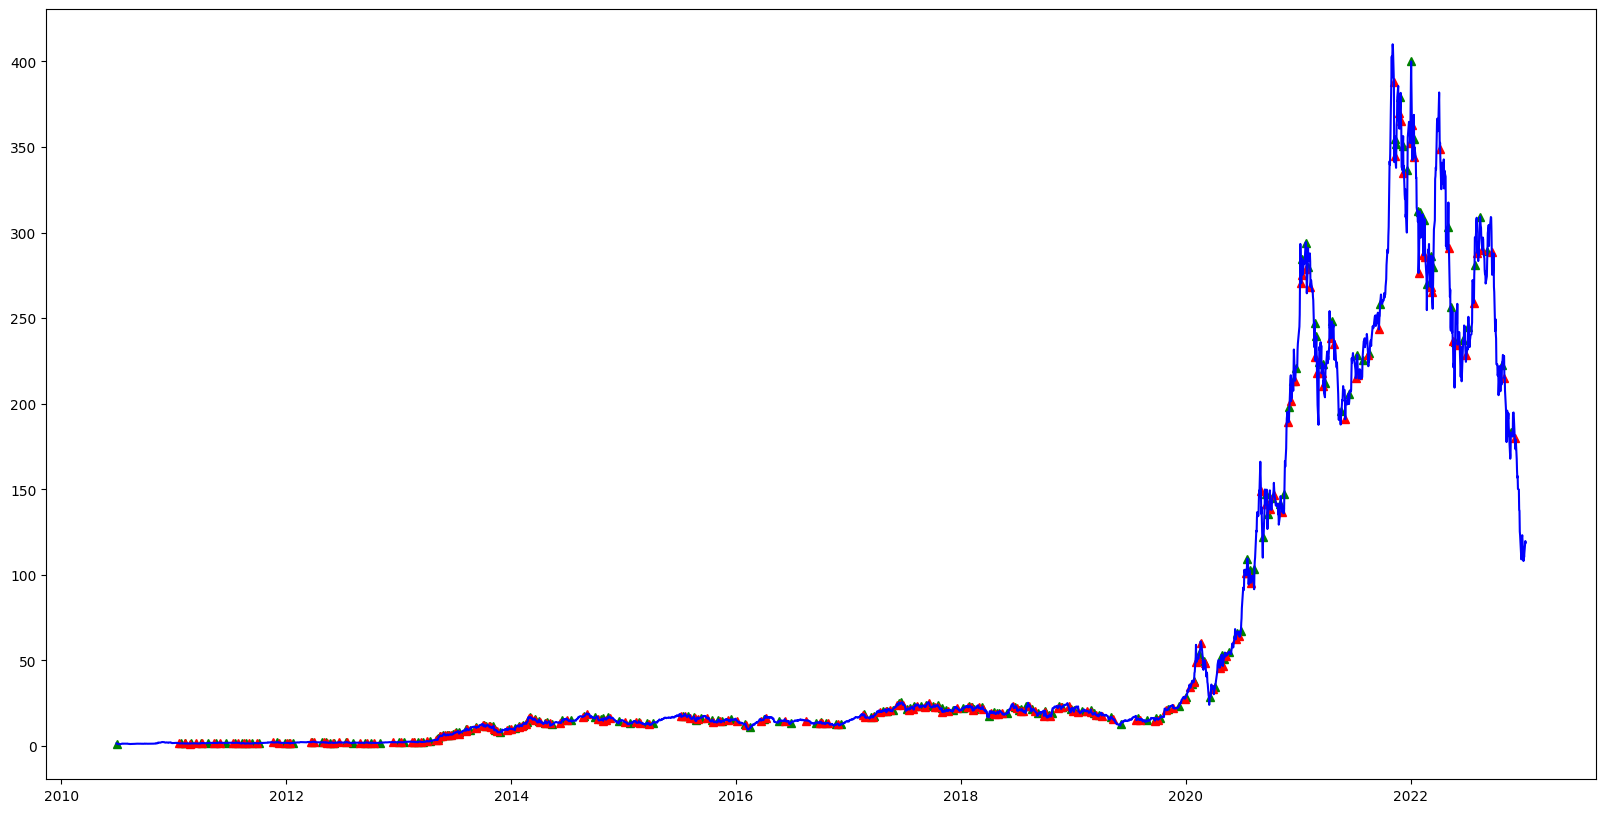

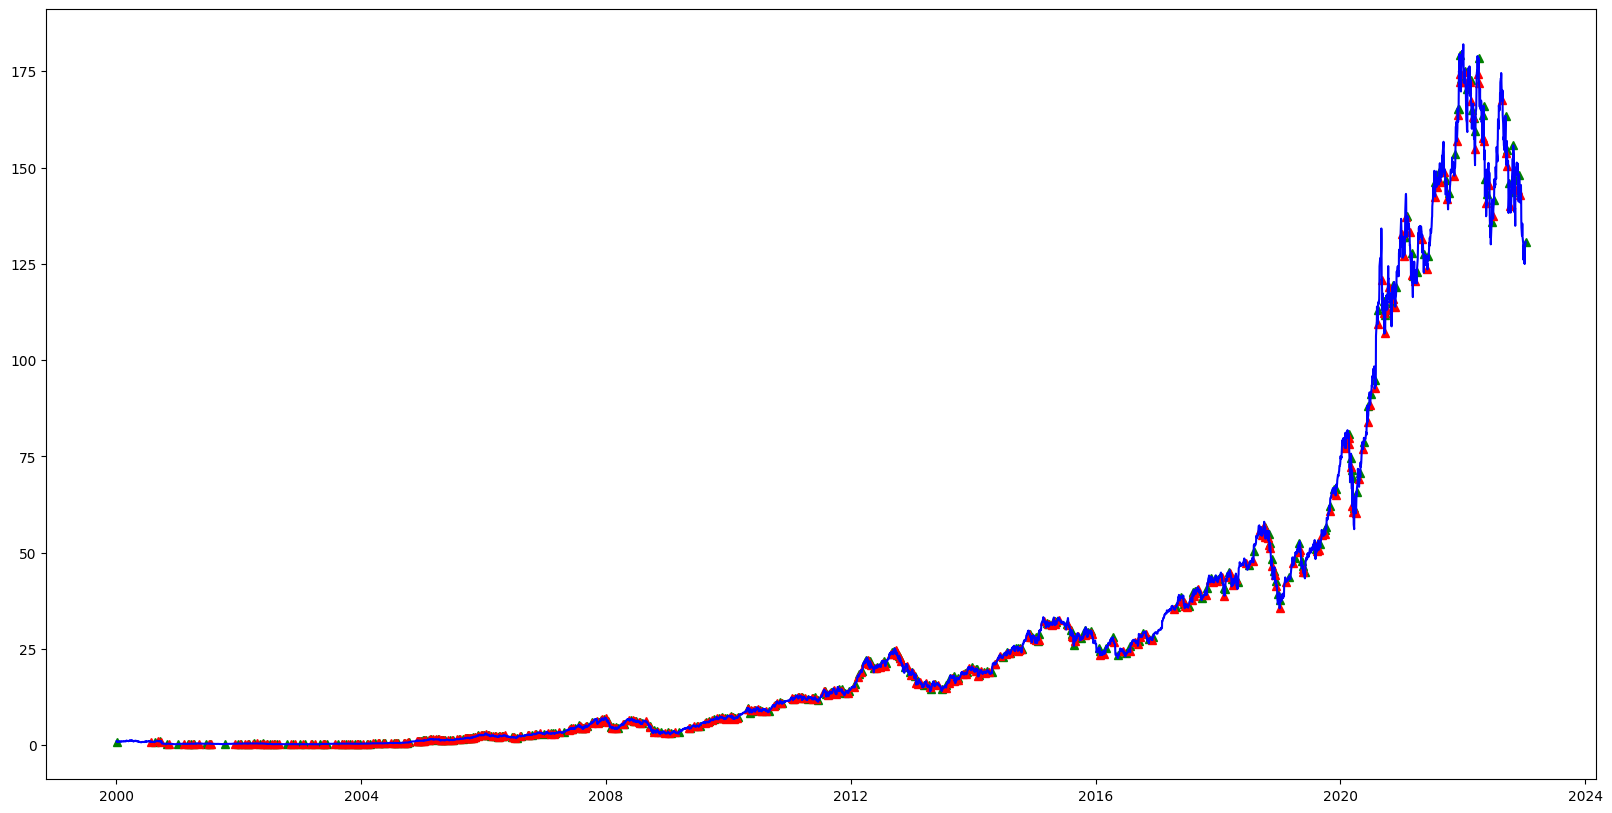

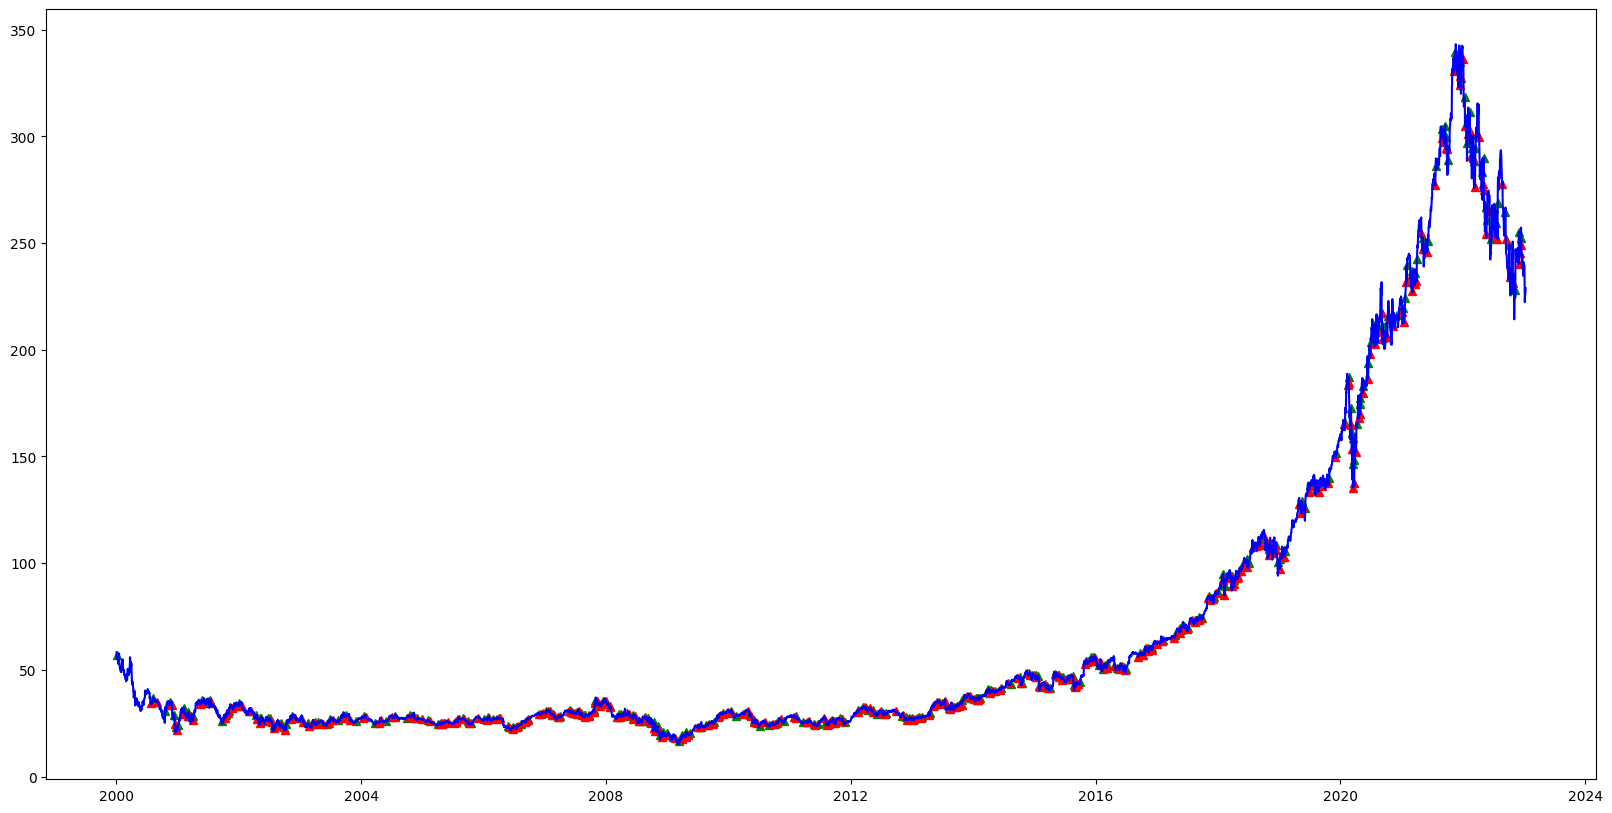

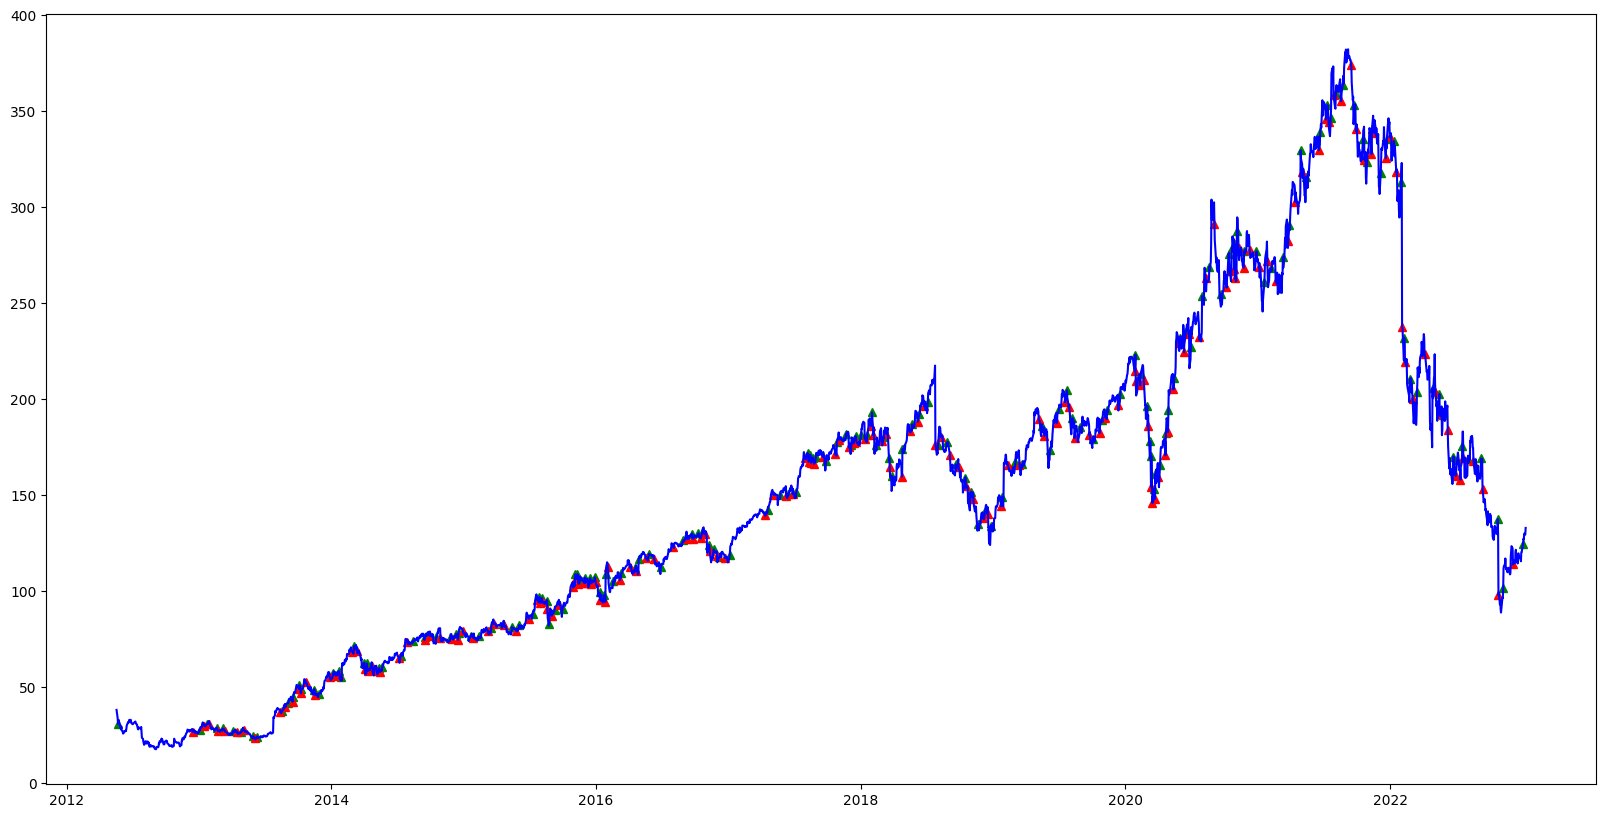

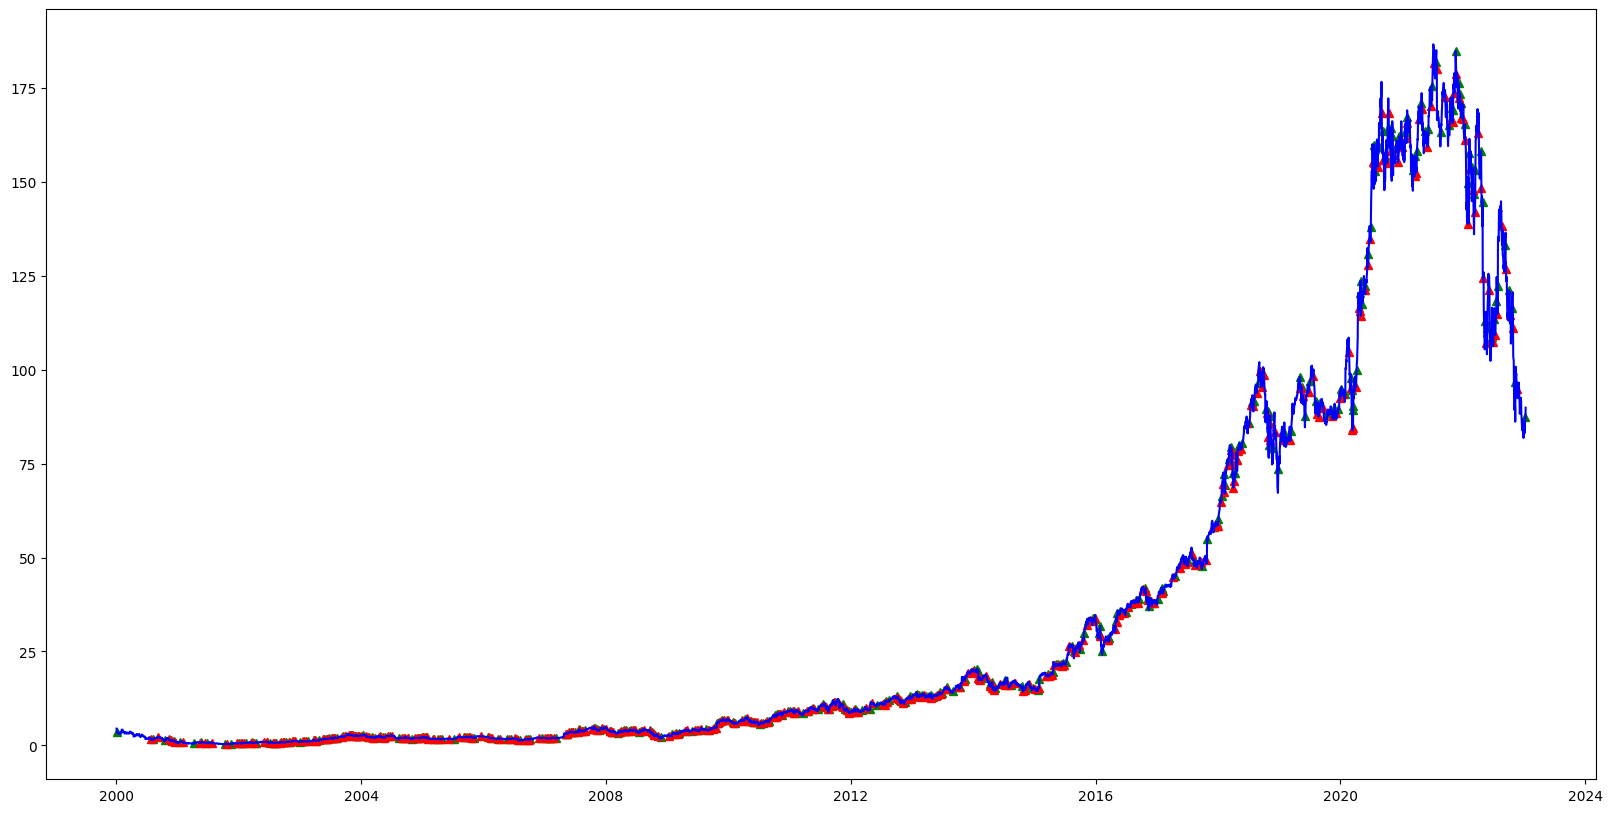

In [23]:
## diversification to increase sharpe  ratio

stockList = ['AAPL','MSFT']
symbol = 'AAPL'

def test_superTrend(symbol,start,end,atr_period,atr_multiplier):
  df = symbol_superTrend(symbol,start,end,atr_period,atr_multiplier)
  entry, exit, roi,equityCurve,returnCurve,allocation = backtest_supertrend(df, 1000000)
  closePlot = df['Close'].reset_index()
  fig, axs = plt.subplots(1, figsize=(20,10))
  axs.plot(*zip(*entry),color='g', linestyle='None', marker='^')
  axs.plot(*zip(*exit), color='red',linestyle='None',marker='^')
  axs.plot(df['Close'],color='b')
  print(symbol," return:",roi)
  return equityCurve,returnCurve 

equityCurve1,returnCurve1  = test_superTrend('TSLA',start,end, period, atr_multiplier)
equityCurve2,returnCurve2 = test_superTrend('AAPL',start,end, period, atr_multiplier)
equityCurve3,returnCurve3  = test_superTrend('MSFT',start,end, period, atr_multiplier)
equityCurve5,returnCurve5  = test_superTrend('META',start,end, period, atr_multiplier)
equityCurve6,returnCurve6 = test_superTrend('AMZN',start,end, period, atr_multiplier)
# equityCurve7,returnCurve7 = test_superTrend('^HSI',start,end, atr_period, atr_multiplier)


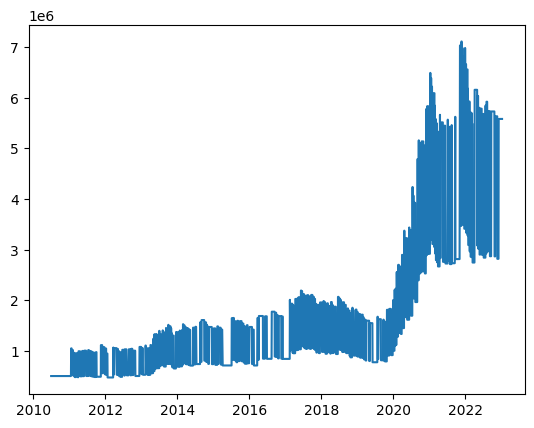

In [24]:
plt.plot(*zip(*equityCurve1))

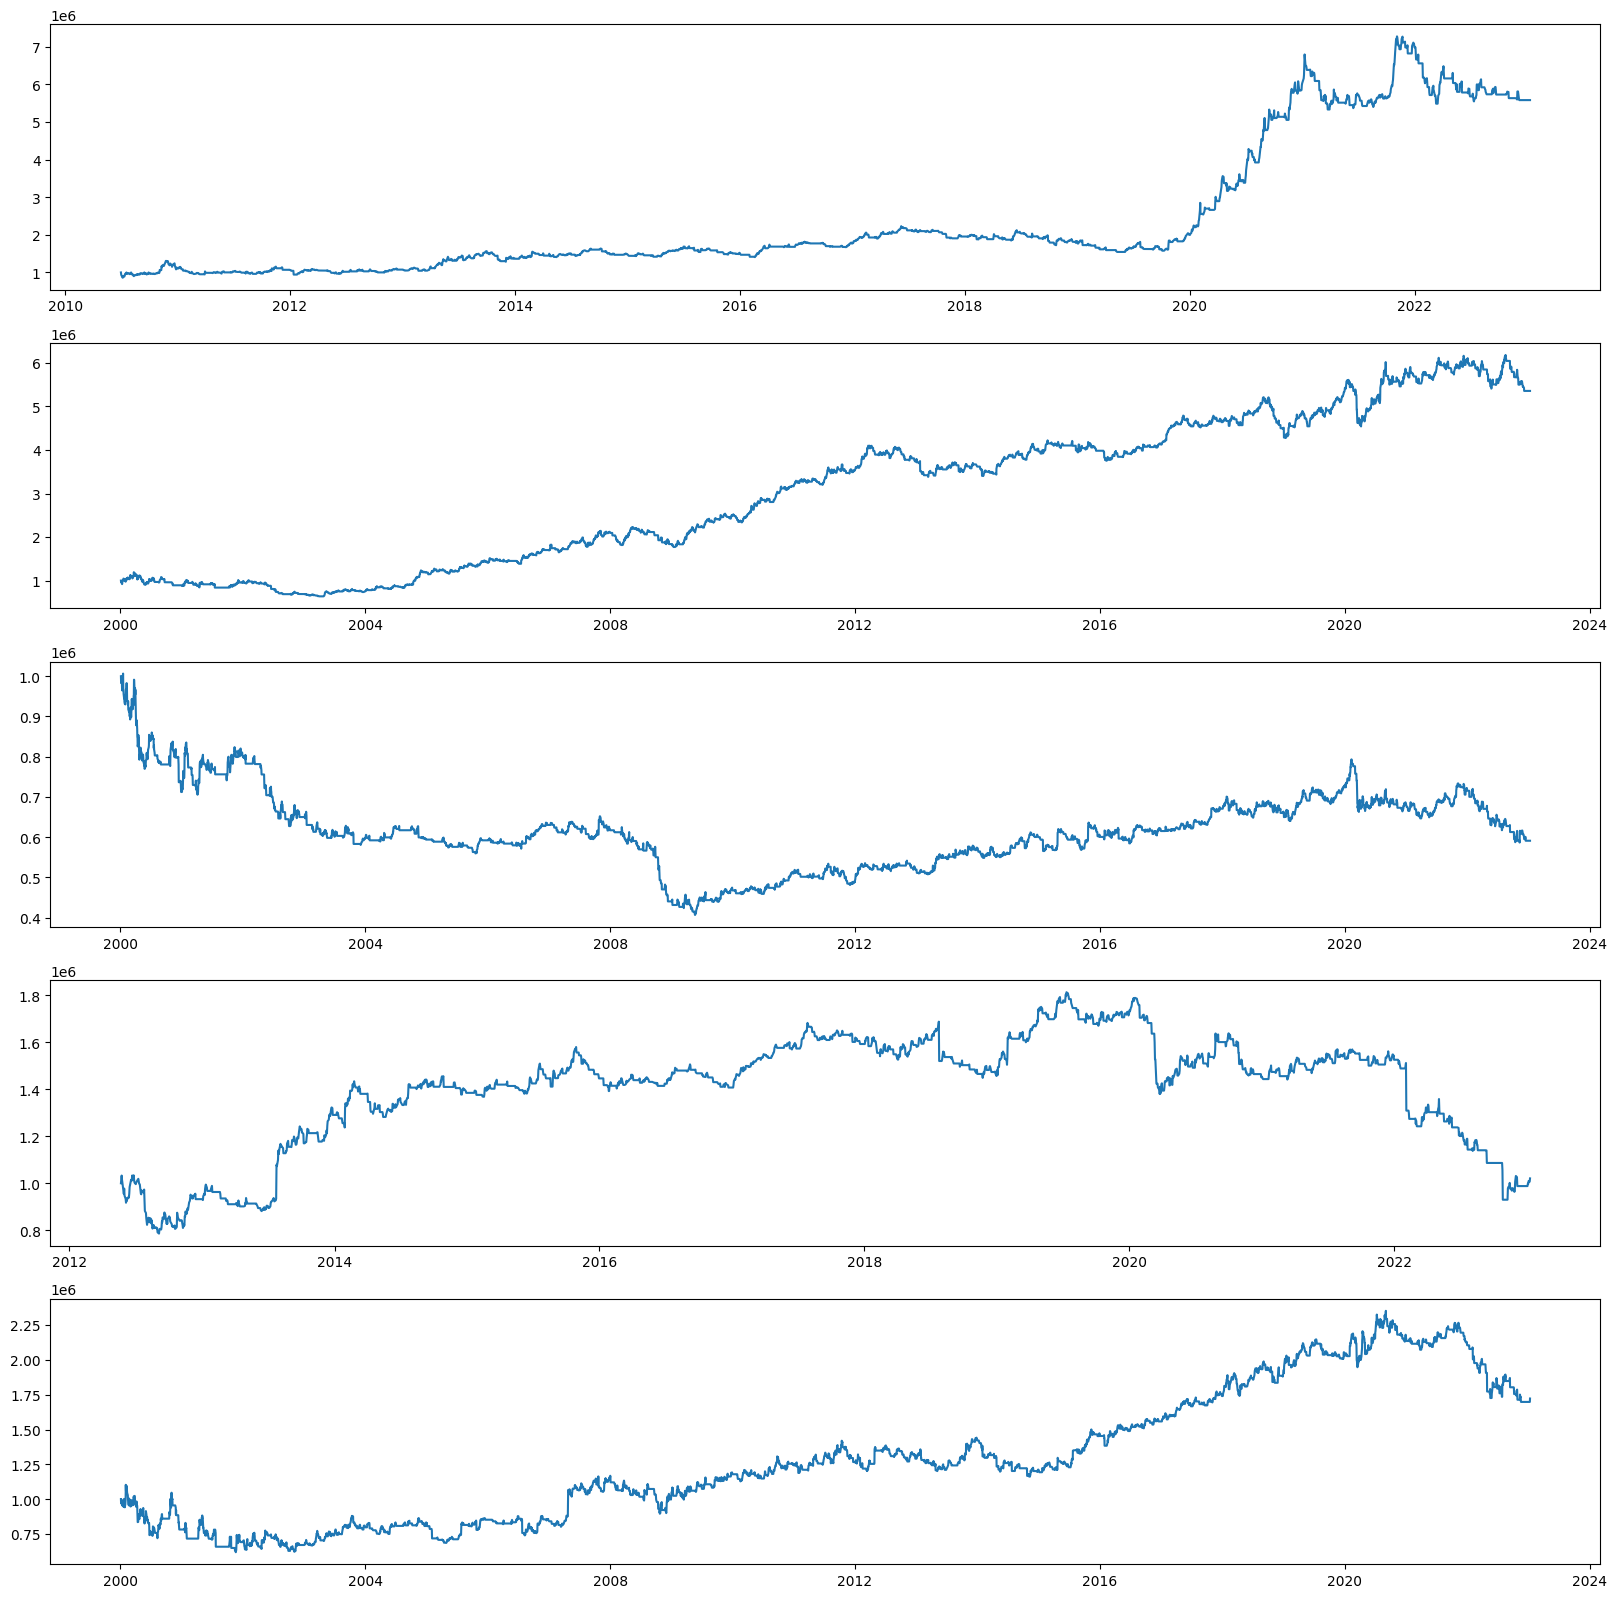

In [25]:
fig,axs = plt.subplots(5,figsize=(20,20))
axs[0].plot(*zip(*returnCurve1))
axs[1].plot(*zip(*returnCurve2))
axs[2].plot(*zip(*returnCurve3))
axs[3].plot(*zip(*returnCurve5))
axs[4].plot(*zip(*returnCurve6))
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


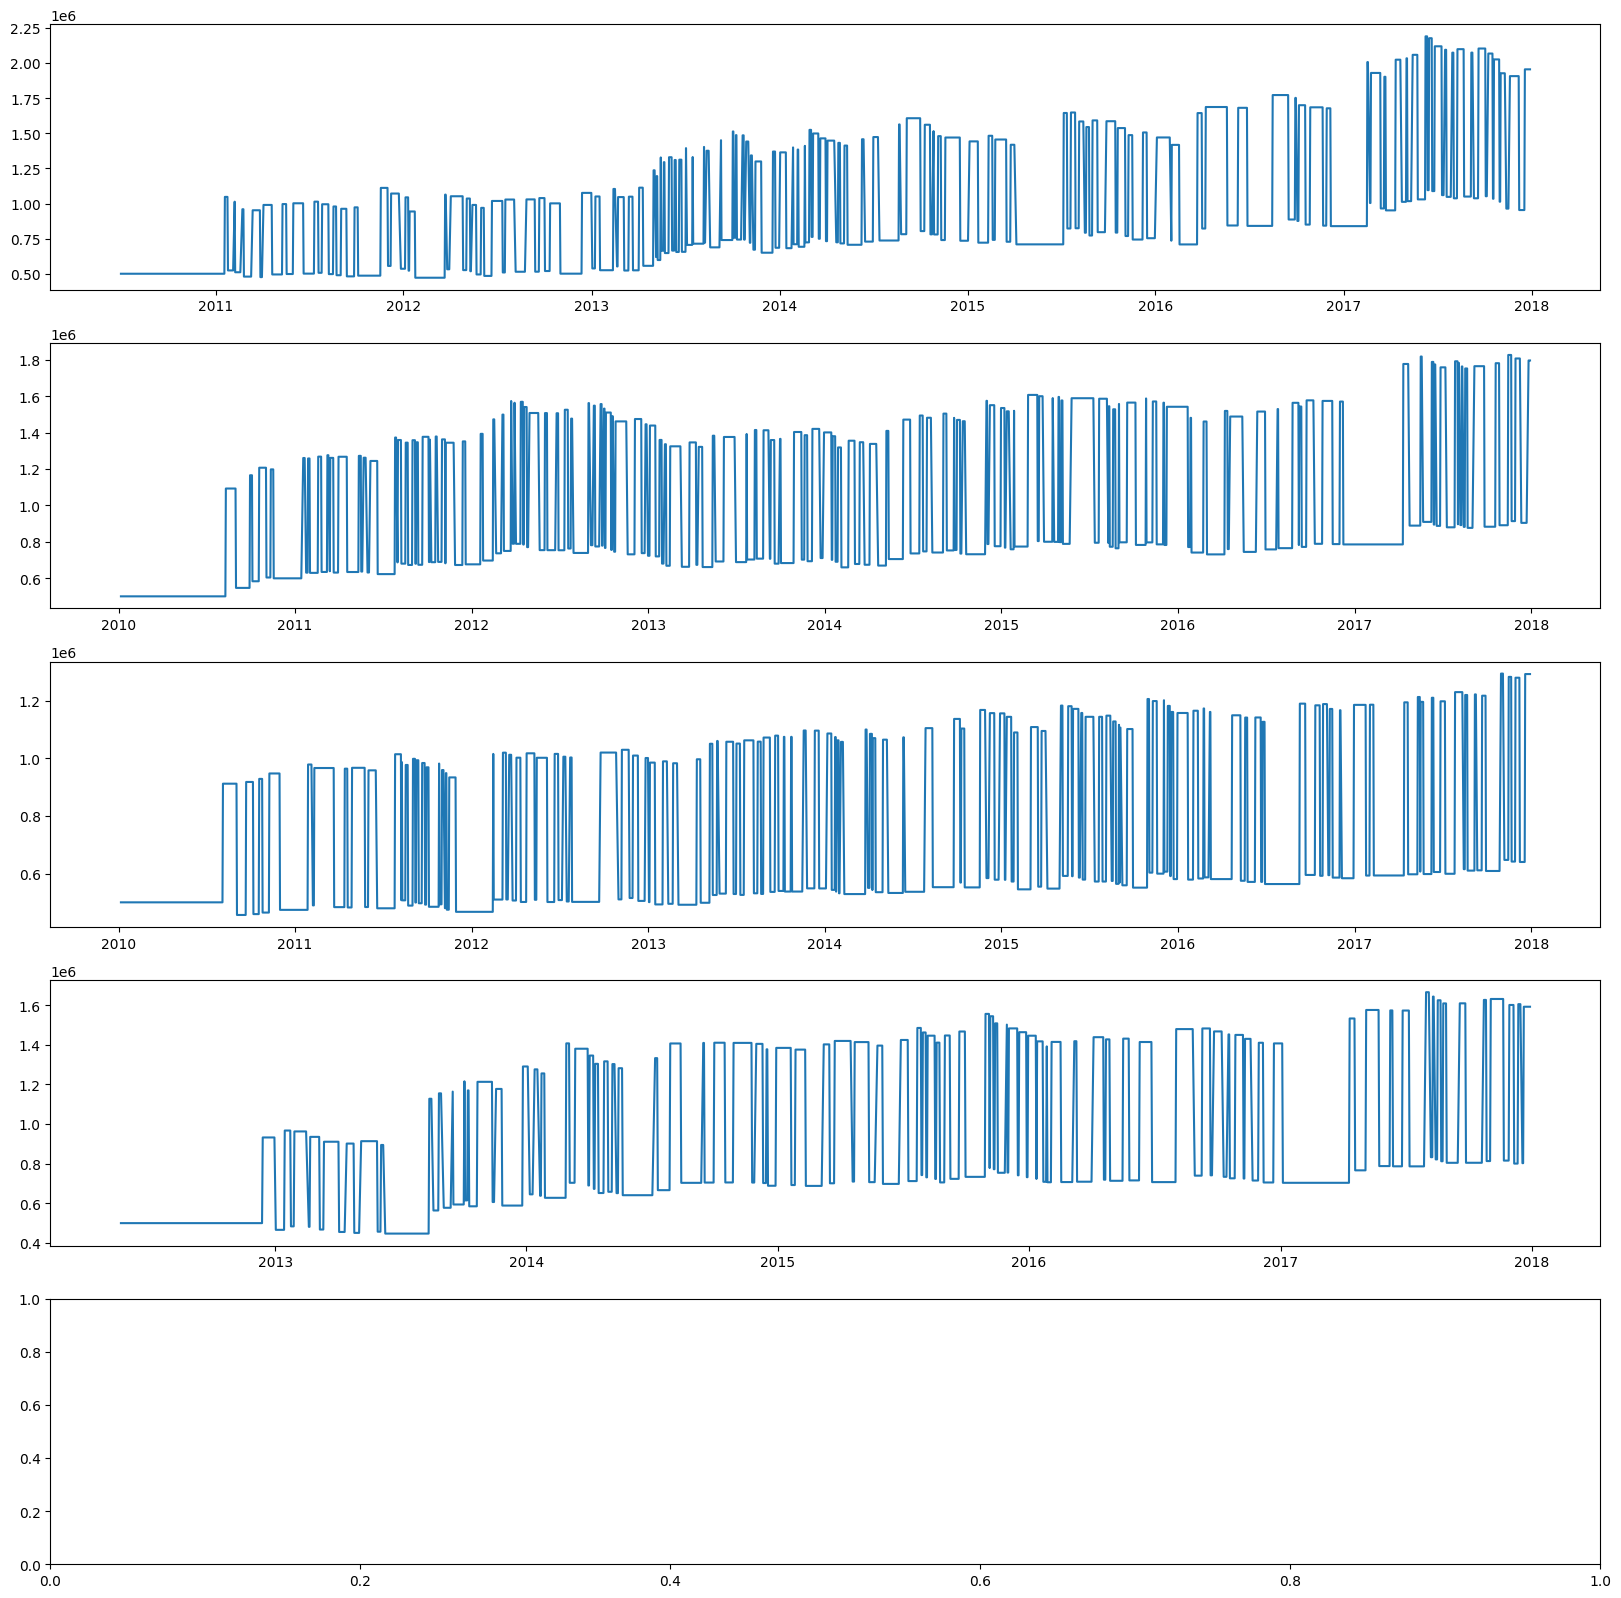

In [12]:
fig,axs = plt.subplots(5,figsize=(20,20))
axs[0].plot(*zip(*equityCurve1))
axs[1].plot(*zip(*equityCurve2))
axs[2].plot(*zip(*equityCurve3))
axs[3].plot(*zip(*equityCurve5))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


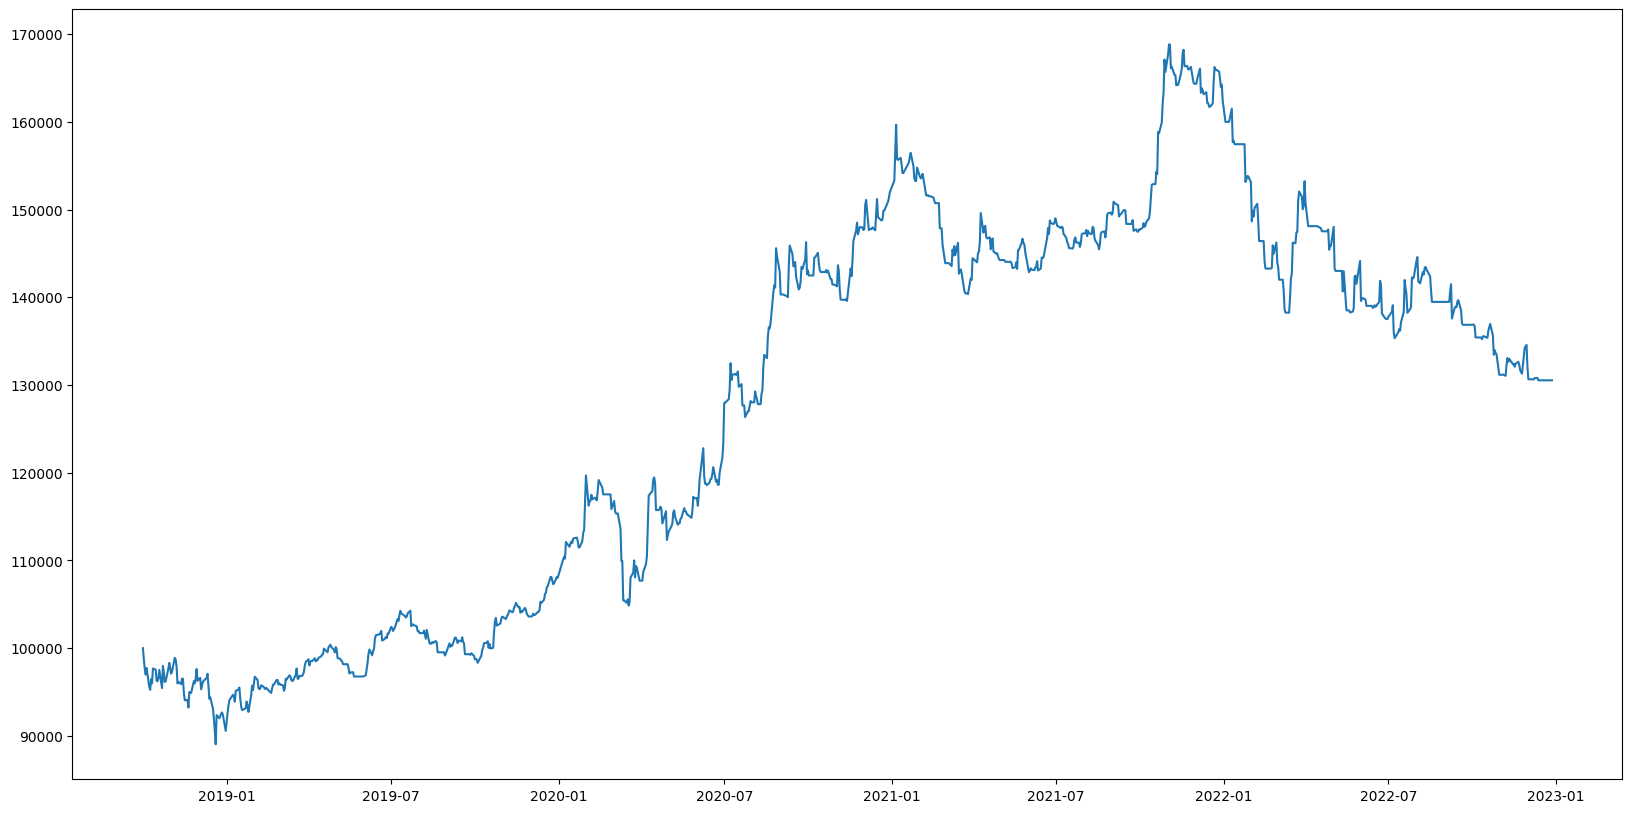

In [13]:
def backtest_multiassetsupertrend(tick_list, investment,start,end):
    eachInvestment = investment/len(tick_list)
    entry = []
    exit = []
    roi = []
    equityCurve = []
    returnCurve =[] 
    combinedReturn = []
    df_list = []
    for i in range(0,len(tick_list)):
      df= symbol_superTrend(tick_list[i],start,end,atr_period,atr_multiplier)
      tempEntry, tempExit, tempRoi, tempEC, tempRC, tempAlloc = backtest_supertrend(df,eachInvestment)
      entry += [tempEntry]
      exit  += [tempExit]
      roi  += [tempRoi]
      equityCurve += [tempEC]
      returnCurve += [tempRC]
      df_list += [df]
    for i in range(0,len(returnCurve[0])):
      tempSum = 0 
      for j in range(0,len(returnCurve)):
        tempSum += returnCurve[j][i][1]
      combinedReturn += [(df_list[0].index[i],tempSum)]
    return combinedReturn
start = '2018-10-01'
end = '2023-01-01'
combinedReturn = backtest_multiassetsupertrend(['TSLA','AAPL','AMZN','MSFT','META'],100000,start, end)
fig, axs = plt.subplots(figsize=(20,10))
axs.plot(*zip(*combinedReturn))
      

#print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')


[*********************100%***********************]  1 of 1 completed


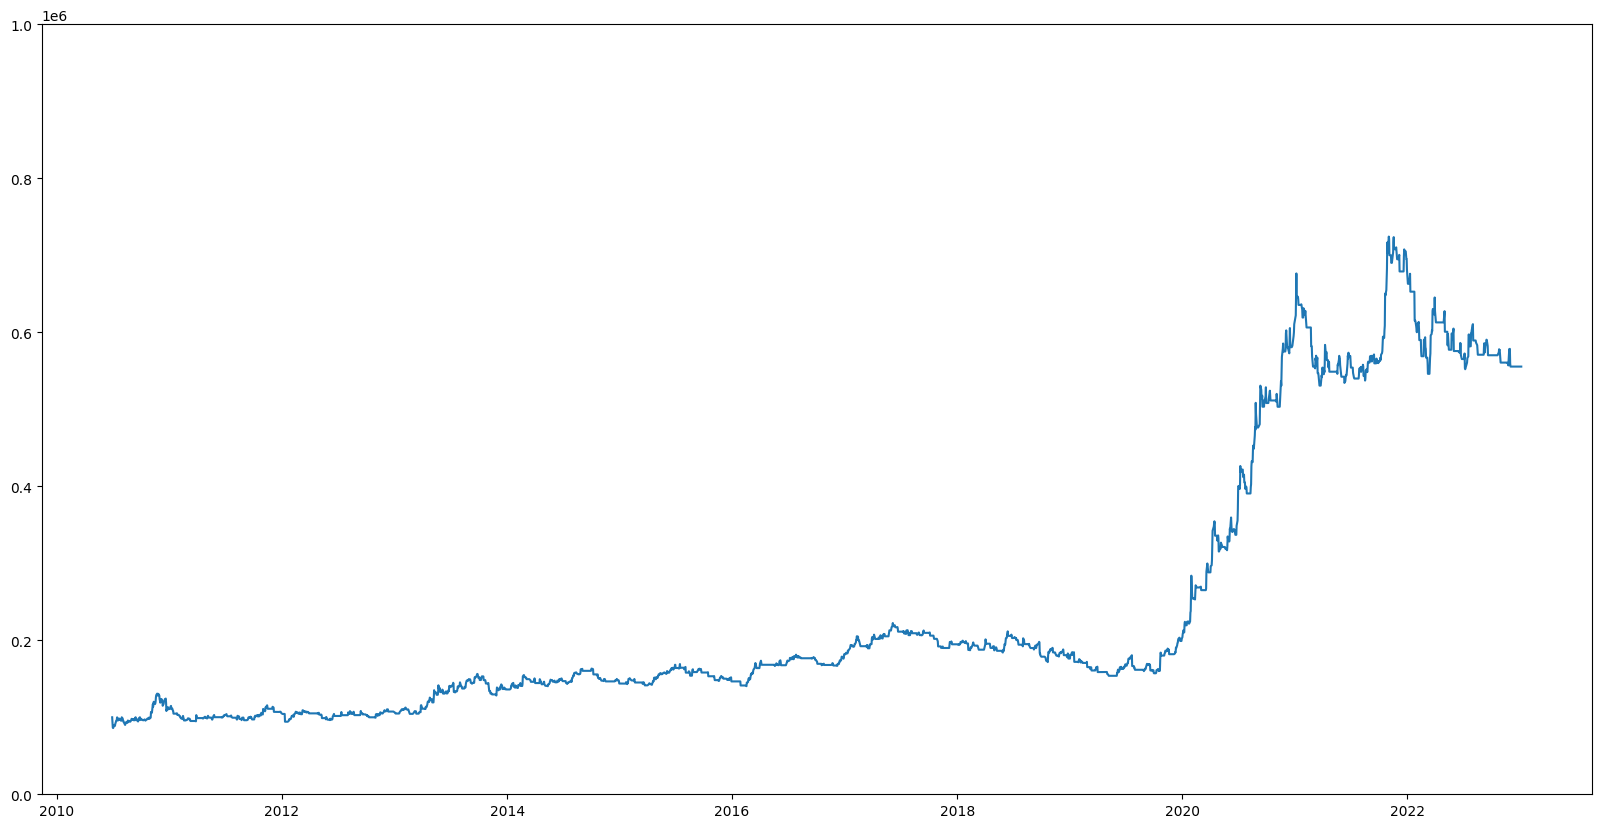

In [26]:
def backtest_multiassetsupertrend(tick_list, investment,start,end):
    eachInvestment = investment/len(tick_list)
    entry = []
    exit = []
    roi = []
    equityCurve = []
    returnCurve =[] 
    combinedReturn = []
    df_list = []
    for i in range(0,len(tick_list)):
      df= symbol_superTrend(tick_list[i],start,end,period,atr_multiplier)
      tempEntry, tempExit, tempRoi, tempEC, tempRC, tempAlloc = backtest_supertrend(df,eachInvestment)
      entry += [tempEntry]
      exit  += [tempExit]
      roi  += [tempRoi]
      equityCurve += [tempEC]
      returnCurve += [tempRC]
      df_list += [df]
    for i in range(0,len(returnCurve[0])):
      tempSum = 0 
      for j in range(0,len(returnCurve)):
        tempSum += returnCurve[j][i][1]
      combinedReturn += [(df_list[0].index[i],tempSum)]
    return combinedReturn
start = '2000-01-01'
end = '2023-01-11'
combinedReturn = backtest_multiassetsupertrend(['TSLA'],100000,start, end)
fig, axs = plt.subplots(figsize=(20,10))
plt.ylim(ymin=0,ymax=1000000)
axs.plot(*zip(*combinedReturn))